# Lab 3 Zadanie - Bell State ZZ
(Wersja  zmodyfikowana na potrzeby MMIK !!!)



In [40]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.qasm import pi

## Building the circuit <a name='basics'></a>

The basic element needed for your first program is the QuantumCircuit.  We begin by creating a `QuantumCircuit` comprised of three qubits.

In [41]:
# Create a Quantum Circuit acting on a quantum register of three qubits
qnumber=2
circ = QuantumCircuit(qnumber)

In [42]:
circ.reset(0)
circ.h(0)
circ.reset(1)
circ.cx(0, 1)


# circ.reset(0)
# circ.h(0)
# circ.reset(1)
# circ.ry(pi * 2. / 3., 1)
# circ.cx(0, 1)

## Visualize Circuit <a name='visualize'></a>

You can visualize your circuit using Qiskit `QuantumCircuit.draw()`, which plots the circuit in the form found in many textbooks.

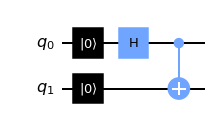

In [43]:
circ.draw('mpl')

In this circuit, the qubits are put in order, with qubit zero at the top and qubit two at the bottom. The circuit is read left to right (meaning that gates that are applied earlier in the circuit show up further to the left).

## Simulating circuits <a name='simulation'></a>

To simulate a circuit we use the quant_info module in Qiskit. This simulator returns the quantum state, which is a complex vector of dimensions $2^n$, where $n$ is the number of qubits 
(so be careful using this as it will quickly get too large to run on your machine).

There are two stages to the simulator. The first is to set the input state and the second to evolve the state by the quantum circuit.

In [44]:
from qiskit.quantum_info import Statevector

# Set the initial state of the simulator to the ground state using from_int
state = Statevector.from_int(0, 2**qnumber)


# Evolve the state by the quantum circuit
state = state.evolve(circ)

#draw using latex
state.draw('latex')

<IPython.core.display.Latex object>

In [45]:
print(state)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


In [46]:
for x in range(pow(2,qnumber)):
    print(x,state[x])

0 (0.7071067811865476+0j)
1 0j
2 0j
3 (0.7071067811865476+0j)


In [47]:
from qiskit.visualization import array_to_latex

#Alternative way of representing in latex
array_to_latex(state)

<IPython.core.display.Latex object>

Qiskit also provides a visualization toolbox to allow you to view the state.

Below, we use the visualization function to plot the qsphere  and a hinton representing the real and imaginary components of the state density matrix $\rho$.

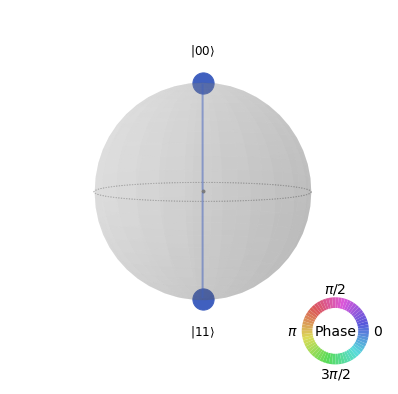

In [11]:
state.draw('qsphere')

## OpenQASM backend

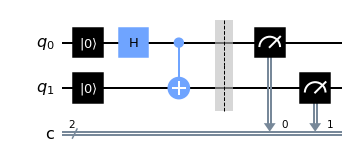

In [12]:
# Create a Quantum Circuit
meas = QuantumCircuit(qnumber, qnumber)
meas.barrier(range(qnumber))
# map the quantum measurement to the classical bits
meas.measure(range(qnumber), range(qnumber))

# The Qiskit circuit object supports composition.
# Here the meas has to be first and front=True (putting it before) 
# as compose must put a smaller circuit into a larger one.
qc = meas.compose(circ, range(qnumber), front=True)

#drawing the circuit
qc.draw('mpl')

This circuit adds a classical register, and three measurements that are used to map the outcome of qubits to the classical bits. 

To simulate this circuit, we use the ``qasm_simulator`` in Qiskit Aer. Each run of this circuit will yield either the bitstring 000 or 111. To build up statistics about the distribution of the bitstrings (to, e.g., estimate $\mathrm{Pr}(000)$), we need to repeat the circuit many times. The number of times the circuit is repeated can be specified in the ``execute`` function, via the ``shots`` keyword.

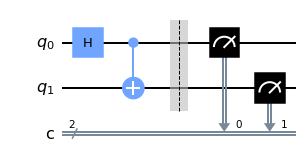

In [13]:
# Adding the transpiler to reduce the circuit to QASM instructions
# supported by the backend
from qiskit import transpile 

# Use Aer's qasm_simulator
from qiskit.providers.aer import QasmSimulator

backend = QasmSimulator()

# First we have to transpile the quantum circuit 
# to the low-level QASM instructions used by the 
# backend
qc_compiled = transpile(qc, backend, optimization_level=3)


qc_compiled.draw('mpl')

In [14]:
# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = backend.run(qc_compiled, shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()

Once you have a result object, you can access the counts via the function `get_counts(circuit)`. This gives you the _aggregated_ binary outcomes of the circuit you submitted.

In [16]:
counts = result_sim.get_counts(qc_compiled)
print(counts)

{'00': 520, '11': 504}


Approximately 50 percent of the time, the output bitstring is 000. Qiskit also provides a function `plot_histogram`, which allows you to view the outcomes. 

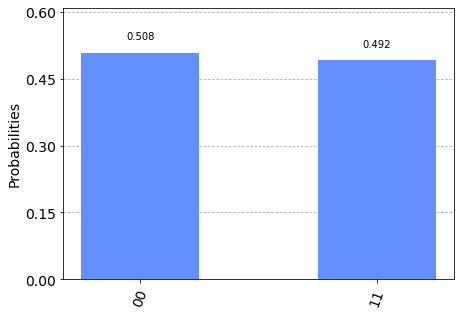

In [17]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

The estimated outcome probabilities $\mathrm{Pr}(000)$ and  $\mathrm{Pr}(111)$ are computed by taking the aggregate counts and dividing by the number of shots (times the circuit was repeated). Try changing the ``shots`` keyword in the ``execute`` function and see how the estimated probabilities change.

### Uruchomienie na prawdziwym urządzeniu

In [18]:
from qiskit import IBMQ 
from qiskit.providers.ibmq import least_busy
IBMQ.load_account() 
provider = IBMQ.get_provider(hub='ibm-q')
n=2
# wybieramy najmniej zajęte urządzenie o liczbie qbitów większej od n, działające i 
#nie będące symulatorem
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits > n and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_lima


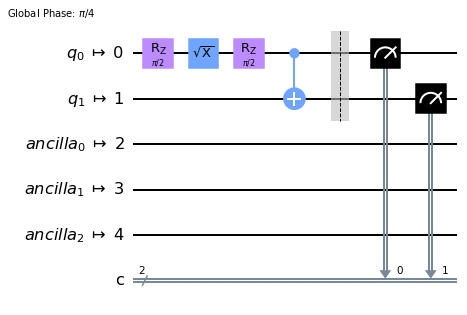

In [19]:
# First we have to transpile the quantum circuit 
# to the low-level QASM instructions used by the 
# backend
#see  target system architecture
#for gates "tricks"  see https://qiskit.org/textbook/ch-gates/more-circuit-identities.html
# see also next film
qc_compiled = transpile(qc, backend, optimization_level=1)

qc_compiled.draw('mpl')

## Komentarz do wyniku transpilacji

Widzimy, że transpilator zamienił bramkę Hadamarda na sekwencję trzech bramek Rz Gate $\frac{\pi}{2}$, SXGate i Rz Gate $\frac{\pi}{2}$. Zrobił tak ponieważ takie bramki są zaimplementowane na poziomie hardwareu, a są równoważne bramce Hadamarda.

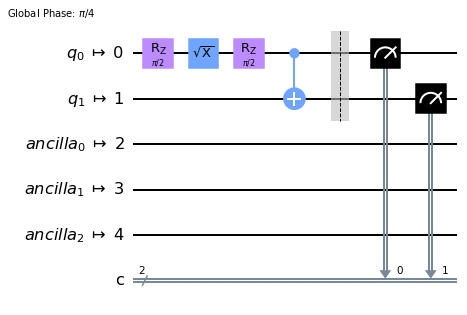

In [20]:
# transpilation with higher optimization level 

qc_compiled = transpile(qc, backend, optimization_level=3)

qc_compiled.draw('mpl')

In [21]:
# Execute the circuit on the real device simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job = backend.run(qc_compiled, shots=1024)

# Grab the results from the job.


from qiskit.tools.monitor import job_monitor

job_monitor(job, interval = 1)

result = job.result()

Job Status: job has successfully run


In [22]:
answer=result.get_counts()

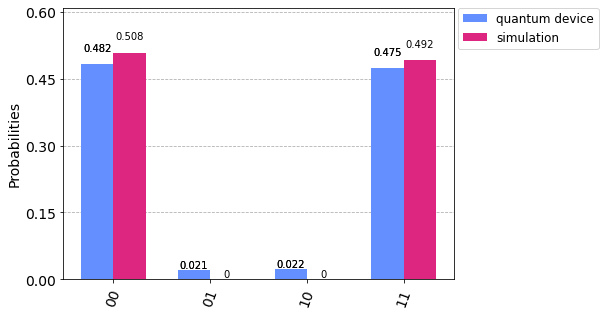

In [23]:
#plot everything
plot_histogram(data=[answer, counts], legend=['quantum device', 'simulation'])

## Komentarz do różnic pomiędzy teoretycznym wynikiem a zmierzonym

Teoretyczne prawdopodobieństwa wynoszą 50% dla stanu <00> i 50% dla stanu <11>, zaobserwowane prawdodpobieństwa na symulatorze
są w okolicach tej liczby - nie wynoszą dokładnie 50/50 ze względu na fakt, że to eksperymentalnie zmierzone prawdopodobieństwo (moglibyśmy dostać tylko raz stan <00> a pozostałe razy <11> i to też jest jak najbardziej możliwe albo mało prawodopodobne - dlatego trzeba uważać przy odczytywaniu wyników eskperymentalnie zmierzonego prawodopodbieństwa).

Na faktycznym komputerze kwantowym oprócz oczekiwanych stanów <00>, <11>, uzyskaliśmy jeszcze stany, które teoretycznie są niemożliwe. Te wyniki biorą się z niedokskonałości komputera kwantowego.

In [24]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright